## **CIFAR10 (CV Pipeline)**
---

@Author: Ziyang Zhang (sidz314), Weichen Song (esswc), Chenkang Zhang (stezhang)

@Version: Nov 15, 2023


# Package Import


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets.cifar10 import load_data
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import randint,uniform
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression

from google.colab import drive
import pandas as pd
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import os


# Data Loading

In [ ]:
def unpickle(path):
    '''
    Get the category list
    '''
    f = open(path, 'rb')
    namedict = pickle.load(f, encoding='latin1')
    f.close()
    return namedict['label_names']


(train, train_y), (test, test_y) = load_data()
category = unpickle('/content/drive/My Drive/CIS519/519_Project/cifar-10-data/batches.meta')

print("Training set shape:", train.shape, train_y.shape)
print("Testing set shape:", test.shape, test_y.shape)
print('Category:', category)

170498071/170498071 [==============================] - 15s 0us/step
Training set shape: (50000, 32, 32, 3) (50000, 1)
Testing set shape: (10000, 32, 32, 3) (10000, 1)
Category: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Visualize 25 images in the train set


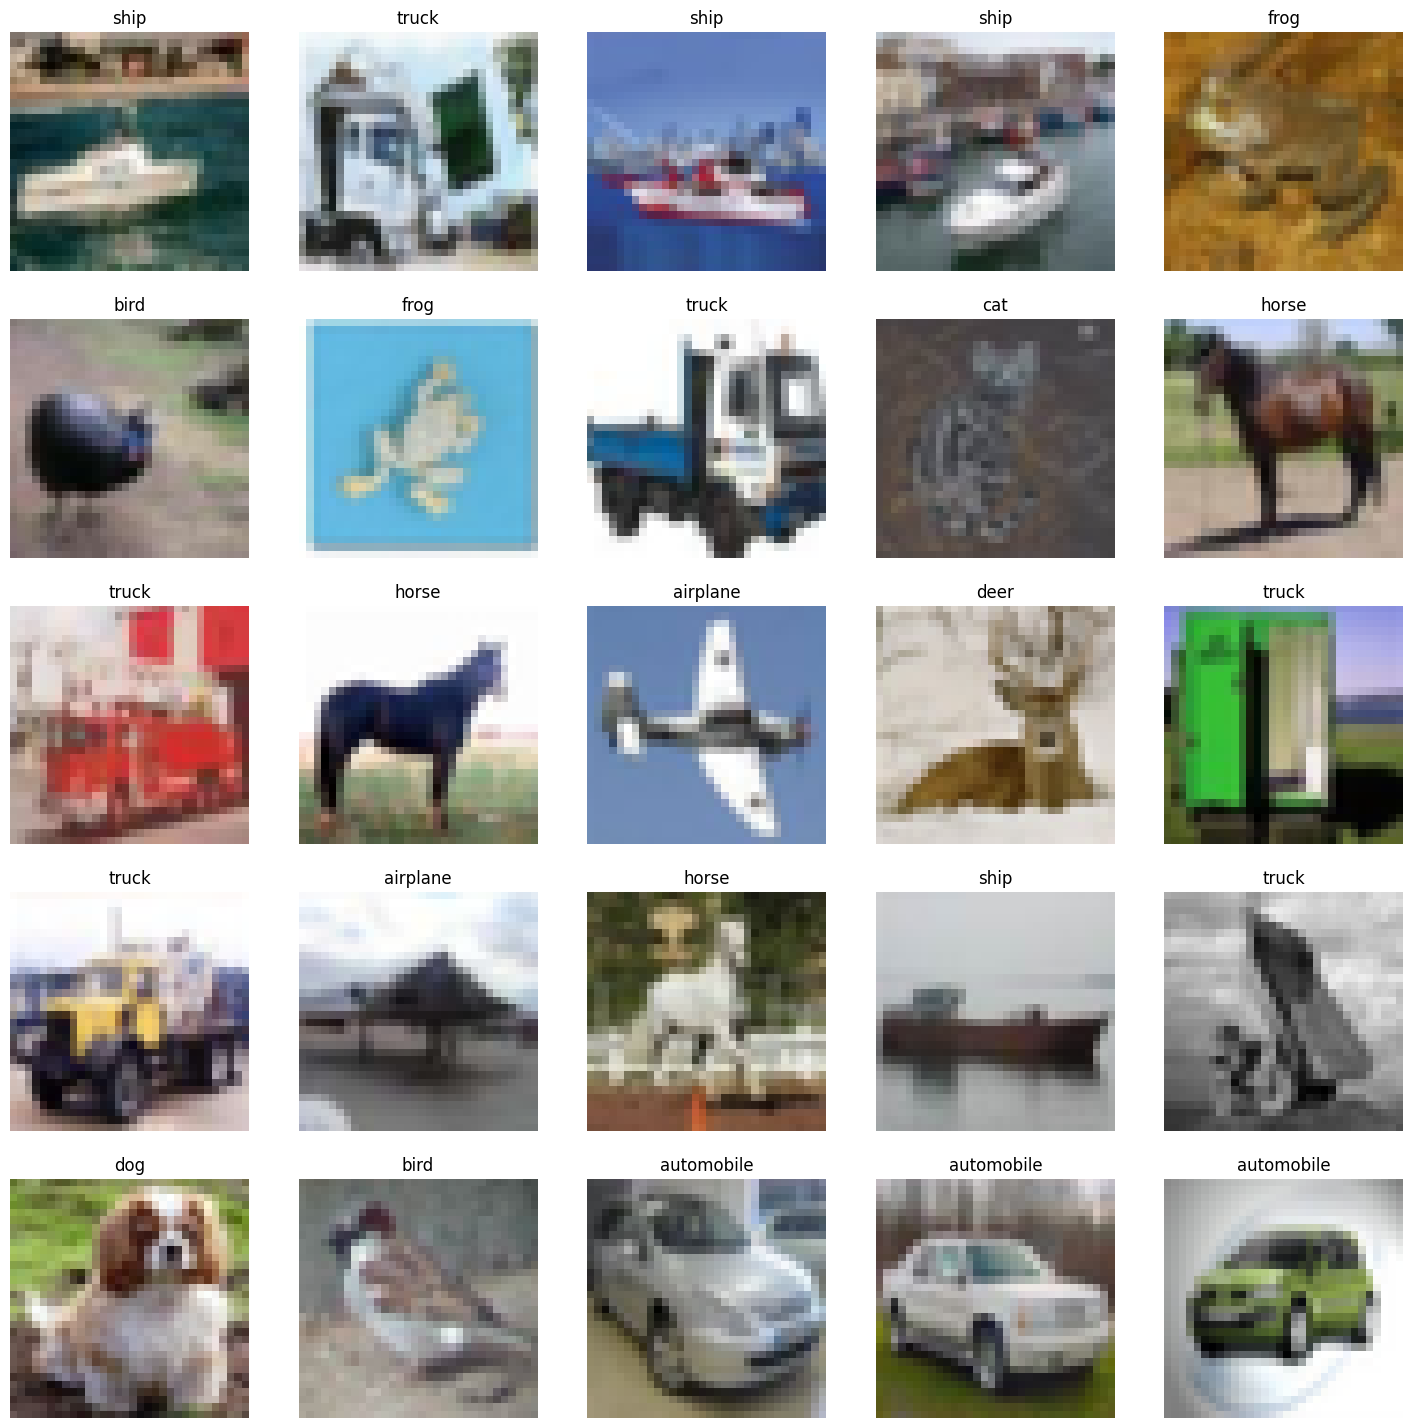

In [ ]:
#Visualizing CIFAR 10 data.  Randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5,5,figsize=(18,18))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(train[i:i+1][0])
        axes1[j][k].set_title(category[int(train_y[i])])


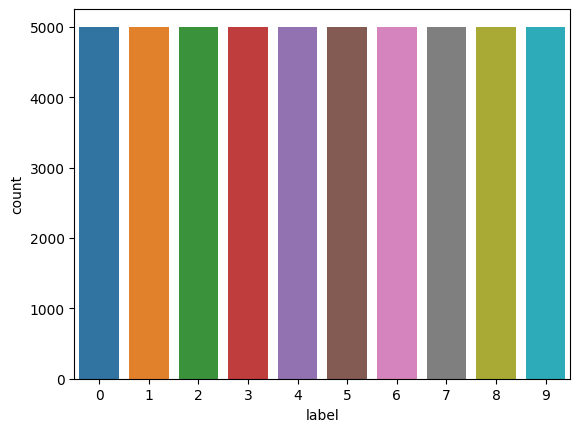

In [ ]:
y_df = pd.DataFrame(train_y)
y_df.columns = ['label']
sns.countplot(y_df,x='label')
plt.show()

# Data Preprocessing

In [ ]:

#We just choose the first 40000 imgs as trainset and the rest as validation set since the original dataset is shuffled.
num_training = 40000
num_validation = 10000
num_test = 10000

#flatten
train_ml = np.reshape(train, (train.shape[0], -1))
test_ml = np.reshape(test, (test.shape[0], -1))

#Scale data
scaler = StandardScaler()
train_ml = scaler.fit_transform(train_ml)
test_ml = scaler.transform(test_ml)

#split the data
X_val = train_ml[-num_validation:, :]
y_val = train_y[-num_validation:]
X_train = train_ml[:num_training, :]
y_train = train[:num_training]
X_test = test_ml[:num_test, :]
y_test = test_y[:num_test]

# Implement a Softmax Classifier


In [ ]:
class SoftmaxClassifier:

    def __init__(self,C=10,D=3072, max_iter=1000, lr=0.01, batch_size=128, reg=0.01,verbose=True):
        """
        Softmax Classifier

        Parameters
        ----------
        C: int, the number of classes
        D: int, dimension of each image
        W: numpy array of shape(C,D), thw weight array
        max_iter : int, default=1000
            Maximum number of iterations of gradient descent
        lr : float, default = 1e-5
             the learning rate
        batch_size : int, default = 32
            batch size for  mini-batch
        reg: float, default = 1e-3
            regularization coefficient
        tol: float, default = 1e-3
            tolerance for loss change
        train_loss: list, the train losses
        train_acc: list,the train accuracy
        val_loss: list, the val losses
        val_acc: list,the val accuracy
        verbose: bool, whether to print progress


        Attributes
        ----------
        train : train the model
        Minibatch: apply the mini-batch gradient descent algorithm
        softmax_fuc: return the softmax score
        computeLoss: retun current loss and gradient
        Accuracy: return the current accuracy(mean accuracy)
        predict : predict the test
        oneHotEncoding: return the one-hot form of y
        """
        self.max_iter = max_iter
        self.lr = lr
        self.batch_size = batch_size
        self.reg = reg
        self.verbose = verbose
        self.W = None
        self.C = C
        self.D = D
        self.train_loss= None
        self.val_loss = None
        self.train_acc = None
        self.val_acc = None
        self.W_his = None

    def train(self, X_train, y_train, X_val, y_val):


        """
        Train the model using mini-batch

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,1)
            The target variable array
        X_val: numpy.ndarray of shape (N1, D)
            The features matrix
        y_val: numpy.ndarray of shape (N1,1)
            The target variable array

        Returns
        -------
        Nothing
        """

        y_train_onehot = self.oneHotEncoding(y_train)
        y_val_onehot = self.oneHotEncoding(y_val)
        self.W = 0.001 * np.random.rand(self.D, self.C)
        self.velocity = np.zeros(self.W.shape)
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.W_his = []
        for e in range(self.max_iter): # loop over max_iter
            trainLoss = self.Minibatch(X_train, y_train_onehot)
            new_w = self.W[:]
            valLoss, _ = self.computeLoss(X_val, y_val_onehot)
            trainAcc = self.Accuracy(X_train, y_train)
            valAcc = self.Accuracy(X_val, y_val)
            self.train_acc.append(trainAcc)
            self.val_acc.append(valAcc)
            self.train_loss.append(trainLoss)
            self.val_loss.append(valLoss)
            if self.verbose:
              print("{:d}\t->\tTrainL : {:.7f}\t|\tTestL : {:.7f}\t|\tTrainAcc : {:.7f}\t|\tTestAcc: {:.7f}"
                    .format(e, trainLoss, valLoss, trainAcc, valAcc))
            if e >5:
              slices = self.val_acc[-5:]
              if all(slices[0] < num for num in slices):
                print('Train Acc did not increase for 5 epochs')
                break

    def Minibatch(self, X, y):

        """
        Using mini batch gradient descent to finish one epoch

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array
        Returns
        -------
        The avergae loss in this epoch
        """

        losses = []
        # Randomly juggle up the data.
        randomIndices = random.sample(range(X.shape[0]), X.shape[0])
        X = X[randomIndices]
        y = y[randomIndices]
        for i in range(0, X.shape[0], self.batch_size):
            Xbatch = X[i:i+self.batch_size]
            ybatch = y[i:i+self.batch_size]

            loss, dw = self.computeLoss(Xbatch, ybatch)

            self.W -= self.lr * dw
            self.W_his.append(dw)
            losses.append(loss)
        return np.sum(losses) / len(losses)

    def softmax_fuc(self, scores):

        """
        Parameters
        ----------
        scores: numpy.ndarray of shape (N, C)
            The dot product of X and W
        Returns
        -------
        The softmax score
        """

        scores -= np.max(scores)
        prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T
        return prob

    def computeLoss(self, X, y_hot):
        """
        Compute the current loss and gradient

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,C)
            The target variable array in one hot format
        Returns
        -------
        The loss and gradient
        """
        numOfSamples = X.shape[0]
        scores = np.dot(X, self.W)
        prob = self.softmax_fuc(scores)

        loss = -np.log(np.max(prob)) * y_hot
        regLoss = (1/2)*self.reg*np.sum(self.W*self.W)
        totalLoss = (np.sum(loss) / numOfSamples) + regLoss
        grad = ((-1 / numOfSamples) * np.dot(X.T, (y_hot - prob))) + (self.reg * self.W)
        return totalLoss, grad



    def Accuracy(self, X, y):

        """
        Compute the mean accuracy

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array in one hot format
        Returns
        -------
        The mean accuracy
        """

        predY = self.predict(X).reshape((-1,1))
        return np.mean(np.equal(y, predY))

    def predict(self, X):

        """
        Predict the given dataset

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        The prediction
        """
        return np.argmax(X.dot(self.W), 1)

    def oneHotEncoding(self, y):

        """
        Generate the one hot format of y

        Parameters
        ----------
        y: numpy.ndarray of shape (N,)
            The target variable array
        Returns
        -------
        The target variable in one hot format
        """

        y = np.asarray(y, dtype='int32')
        if len(y) > 1:
            y = y.reshape(-1)
        if not self.C:
            self.C = np.max(y) + 1
        y_hot = np.zeros((len(y), self.C))
        y_hot[np.arange(len(y)), y] = 1
        return np.eye(self.C)[y]


# Hyperparameter Tune and Test


In [ ]:
acc_hist_val = pd.DataFrame()
cost_hist_val = pd.DataFrame()
acc_hist_test = pd.DataFrame()
acc_hist_train = pd.DataFrame()
cost_hist_train = pd.DataFrame()
learning_rate = [0.0005,0.001, 0.01, 0.1, 1.0]
regs = [0.01,0.1,0.5,1]
for alpha in learning_rate:
  for reg in regs:
    model = SoftmaxClassifier(C = 10,D = 3072,lr = alpha, max_iter = 70, batch_size = 128, reg = reg,verbose=False)
    model.train(X_train,y_train,X_val,y_val)
    cur_key = 'lr: '+str(alpha)+', reg: '+str(reg)

    acc_hist_val[cur_key] = model.val_acc
    cost_hist_val[cur_key] = model.val_loss
    acc_hist_train[cur_key] = model.train_acc
    cost_hist_train[cur_key] = model.train_loss

    y_pred = model.predict(X_test)
    acc_hist_test[cur_key] = [np.mean(np.equal(y_test, y_pred.reshape(-1,1)))]
    print(f'Test for {cur_key} has completed.')


Test for lr: 0.0005, reg: 0.01 has completed.
Test for lr: 0.0005, reg: 0.1 has completed.
Test for lr: 0.0005, reg: 0.5 has completed.
Test for lr: 0.0005, reg: 1 has completed.
Test for lr: 0.001, reg: 0.01 has completed.
Test for lr: 0.001, reg: 0.1 has completed.
Test for lr: 0.001, reg: 0.5 has completed.
Test for lr: 0.001, reg: 1 has completed.
Test for lr: 0.01, reg: 0.01 has completed.
Test for lr: 0.01, reg: 0.1 has completed.
Test for lr: 0.01, reg: 0.5 has completed.
Test for lr: 0.01, reg: 1 has completed.
Test for lr: 0.1, reg: 0.01 has completed.
Test for lr: 0.1, reg: 0.1 has completed.
Test for lr: 0.1, reg: 0.5 has completed.
Test for lr: 0.1, reg: 1 has completed.


<ipython-input-7-6124009ef1c3>:148: RuntimeWarning: invalid value encountered in divide
  prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T


Test for lr: 1.0, reg: 0.01 has completed.


<ipython-input-7-6124009ef1c3>:148: RuntimeWarning: invalid value encountered in divide
  prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T


Test for lr: 1.0, reg: 0.1 has completed.


<ipython-input-7-6124009ef1c3>:148: RuntimeWarning: invalid value encountered in divide
  prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T


Test for lr: 1.0, reg: 0.5 has completed.


<ipython-input-7-6124009ef1c3>:148: RuntimeWarning: invalid value encountered in divide
  prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T


Test for lr: 1.0, reg: 1 has completed.


In [ ]:
print(f'----------Training accuracy is----------')
acc_hist_train.tail(1)

----------Training accuracy is----------


,"lr: 0.0005, reg: 0.01","lr: 0.0005, reg: 0.1","lr: 0.0005, reg: 0.5","lr: 0.0005, reg: 1","lr: 0.001, reg: 0.01","lr: 0.001, reg: 0.1","lr: 0.001, reg: 0.5","lr: 0.001, reg: 1","lr: 0.01, reg: 0.01","lr: 0.01, reg: 0.1","lr: 0.01, reg: 0.5","lr: 0.01, reg: 1","lr: 0.1, reg: 0.01","lr: 0.1, reg: 0.1","lr: 0.1, reg: 0.5","lr: 0.1, reg: 1","lr: 1.0, reg: 0.01","lr: 1.0, reg: 0.1","lr: 1.0, reg: 0.5","lr: 1.0, reg: 1"
69,0.441675,0.43235,0.4129,0.39915,0.45025,0.435675,0.4108,0.398125,0.448225,0.416975,0.3793,0.3483,0.279325,0.16075,0.2059,0.187075,0.09965,0.09965,0.09965,0.09965


In [ ]:
print(f'----------Val accuracy is----------')
acc_hist_val.tail(1)

----------Val accuracy is----------


,"lr: 0.0005, reg: 0.01","lr: 0.0005, reg: 0.1","lr: 0.0005, reg: 0.5","lr: 0.0005, reg: 1","lr: 0.001, reg: 0.01","lr: 0.001, reg: 0.1","lr: 0.001, reg: 0.5","lr: 0.001, reg: 1","lr: 0.01, reg: 0.01","lr: 0.01, reg: 0.1","lr: 0.01, reg: 0.5","lr: 0.01, reg: 1","lr: 0.1, reg: 0.01","lr: 0.1, reg: 0.1","lr: 0.1, reg: 0.5","lr: 0.1, reg: 1","lr: 1.0, reg: 0.01","lr: 1.0, reg: 0.1","lr: 1.0, reg: 0.5","lr: 1.0, reg: 1"
69,0.4039,0.4047,0.3932,0.3824,0.406,0.401,0.3883,0.3806,0.3851,0.3887,0.3671,0.3406,0.2605,0.1589,0.2038,0.1836,0.1014,0.1014,0.1014,0.1014


In [ ]:
print(f'----------Test accuracy is----------')
acc_hist_test

----------Test accuracy is----------


,"lr: 0.0005, reg: 0.01","lr: 0.0005, reg: 0.1","lr: 0.0005, reg: 0.5","lr: 0.0005, reg: 1","lr: 0.001, reg: 0.01","lr: 0.001, reg: 0.1","lr: 0.001, reg: 0.5","lr: 0.001, reg: 1","lr: 0.01, reg: 0.01","lr: 0.01, reg: 0.1","lr: 0.01, reg: 0.5","lr: 0.01, reg: 1","lr: 0.1, reg: 0.01","lr: 0.1, reg: 0.1","lr: 0.1, reg: 0.5","lr: 0.1, reg: 1","lr: 1.0, reg: 0.01","lr: 1.0, reg: 0.1","lr: 1.0, reg: 0.5","lr: 1.0, reg: 1"
0,0.4151,0.4094,0.4012,0.3912,0.4113,0.4104,0.401,0.3906,0.3897,0.3953,0.364,0.3362,0.261,0.1584,0.2066,0.1798,0.1,0.1,0.1,0.1


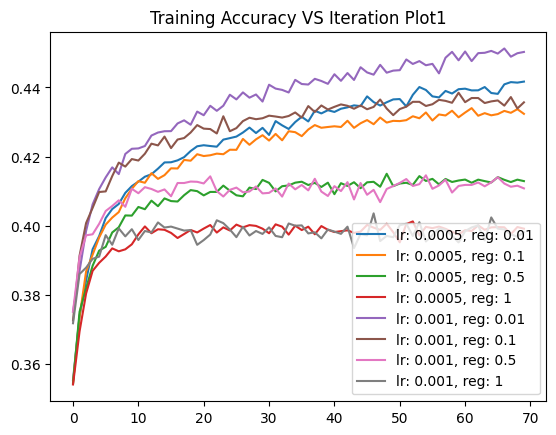

In [ ]:
hist = acc_hist_train.iloc[:,0:8]
for x in hist.columns:
  plt.plot(range(70),acc_hist_train[x],label=x)
plt.title('Training Accuracy VS Iteration Plot1')
plt.legend()
plt.show()

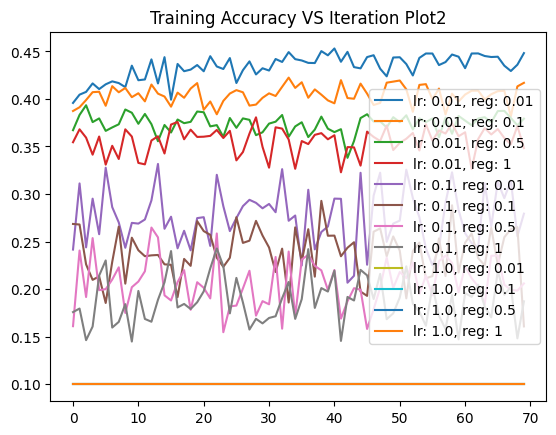

In [ ]:
hist = acc_hist_train.iloc[:,8:20]
for x in hist.columns:
  plt.plot(range(70),acc_hist_train[x],label=x)
plt.title('Training Accuracy VS Iteration Plot2')
plt.legend()
plt.show()

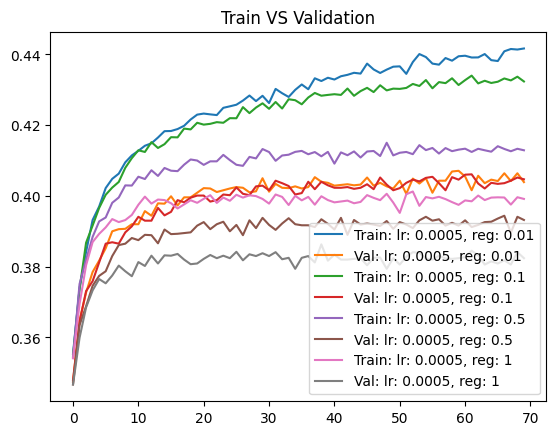

In [ ]:
hist = acc_hist_train.iloc[:,0:4]
for x in hist.columns:
  plt.plot(range(70),acc_hist_train[x],label=str('Train: '+x))
  plt.plot(range(70),acc_hist_val[x],label=str('Val: '+x))
plt.title('Train VS Validation')
plt.legend()
plt.show()

# Conclusion
We found that lr=0.0005,reg=0.01 has the best performance on validation set.

Noticed that,for the same learning rate, the higher the regularization coffecient, the lower the performance. It is because our training data size is sufficient large and softmax classifier hardly overfit the data. In stead, the naive softmax classifier cannot fit to all the data since its capacity is relaicely small compared with nerual network


# Analysis of PCA


In [ ]:
model = SoftmaxClassifier(C = 10,D = 3072,lr = 0.0005, max_iter = 70, batch_size = 128, reg = 0.01,verbose=True)
model.train(X_train,y_train,X_val,y_val)

y_pred = model.predict(X_test)

0	->	TrainL : 0.7751651	|	TestL : 0.2938515	|	TrainAcc : 0.3555250	|	TestAcc: 0.3495000
1	->	TrainL : 0.4549606	|	TestL : 0.2011840	|	TrainAcc : 0.3755250	|	TestAcc: 0.3641000
2	->	TrainL : 0.3945820	|	TestL : 0.1625740	|	TrainAcc : 0.3865500	|	TestAcc: 0.3741000
3	->	TrainL : 0.3573821	|	TestL : 0.1349945	|	TrainAcc : 0.3928000	|	TestAcc: 0.3781000
4	->	TrainL : 0.3301075	|	TestL : 0.1049183	|	TrainAcc : 0.3971750	|	TestAcc: 0.3808000
5	->	TrainL : 0.3050575	|	TestL : 0.0867481	|	TrainAcc : 0.4003000	|	TestAcc: 0.3837000
6	->	TrainL : 0.2846038	|	TestL : 0.0742405	|	TrainAcc : 0.4044250	|	TestAcc: 0.3873000
7	->	TrainL : 0.2764736	|	TestL : 0.0622115	|	TrainAcc : 0.4061750	|	TestAcc: 0.3892000
8	->	TrainL : 0.2620335	|	TestL : 0.0513702	|	TrainAcc : 0.4087750	|	TestAcc: 0.3910000
9	->	TrainL : 0.2531533	|	TestL : 0.0455345	|	TrainAcc : 0.4105250	|	TestAcc: 0.3920000
10	->	TrainL : 0.2411331	|	TestL : 0.0420285	|	TrainAcc : 0.4095750	|	TestAcc: 0.3914000
11	->	TrainL : 0.2341130	|	Test

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy of data without PCA is {accuracy}')


The accuracy of data without PCA is 0.4135


In [ ]:
pca = PCA()

# Fit the data and transform it to the 2 principal components
principal_components = pca.fit_transform(X_train)

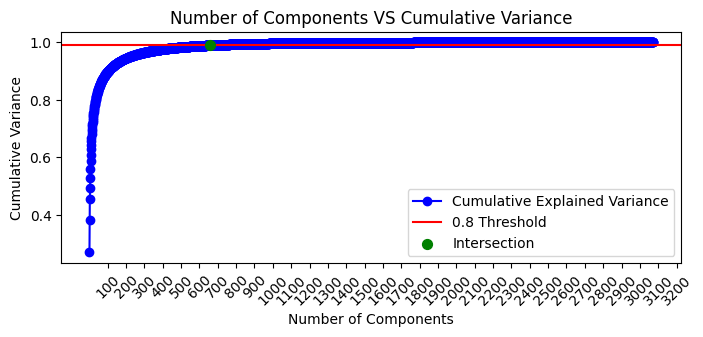

The number of principal components that contribute to more than 99% variance is 659


In [ ]:
explained_variance_ratios =pca.explained_variance_ratio_
cum_evr = np.cumsum(pca.explained_variance_ratio_)
intersection_idx = np.argmax(cum_evr >= 0.99)
plt.figure(figsize=(8, 3))
number_of_components= range(1,X_train.shape[1]+1)
plt.plot(number_of_components,cum_evr,'bo-', label='Cumulative Explained Variance')
plt.xticks([i*100 for i in range(1,X_train.shape[1]+1)],rotation=45)
plt.xlabel('Number of Components')
plt.ylabel("Cumulative Variance")
plt.title("Number of Components VS Cumulative Variance")
plt.axhline(y=0.99,color = 'red', label='0.8 Threshold')
plt.scatter(x=intersection_idx, y=cum_evr[intersection_idx], color='green', label='Intersection', zorder=5, s=50)
plt.legend()
plt.show()
print(f'The number of principal components that contribute to more than 99% variance is {intersection_idx}')

In [ ]:
n_components = intersection_idx + 1

pca=PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

model = SoftmaxClassifier(C = 10,D = 660,lr = 0.001, max_iter = 70, batch_size = 128, reg = 0.01,verbose=True)
model.train(X_train_pca,y_train,X_val_pca,y_val)


0	->	TrainL : 0.5877600	|	TestL : 0.2210951	|	TrainAcc : 0.3746000	|	TestAcc: 0.3641000
1	->	TrainL : 0.3685608	|	TestL : 0.1411754	|	TrainAcc : 0.3883250	|	TestAcc: 0.3737000
2	->	TrainL : 0.3149283	|	TestL : 0.0870351	|	TrainAcc : 0.3964250	|	TestAcc: 0.3812000
3	->	TrainL : 0.2802435	|	TestL : 0.0626174	|	TrainAcc : 0.4035250	|	TestAcc: 0.3871000
4	->	TrainL : 0.2503887	|	TestL : 0.0454668	|	TrainAcc : 0.4075000	|	TestAcc: 0.3901000
5	->	TrainL : 0.2349193	|	TestL : 0.0431485	|	TrainAcc : 0.4133500	|	TestAcc: 0.3962000
6	->	TrainL : 0.2209334	|	TestL : 0.0388706	|	TrainAcc : 0.4146750	|	TestAcc: 0.3964000
7	->	TrainL : 0.2097385	|	TestL : 0.0326211	|	TrainAcc : 0.4148250	|	TestAcc: 0.3972000
8	->	TrainL : 0.2023703	|	TestL : 0.0307908	|	TrainAcc : 0.4183250	|	TestAcc: 0.3972000
9	->	TrainL : 0.1949860	|	TestL : 0.0280425	|	TrainAcc : 0.4213500	|	TestAcc: 0.4009000
10	->	TrainL : 0.1846951	|	TestL : 0.0250757	|	TrainAcc : 0.4195750	|	TestAcc: 0.3979000
11	->	TrainL : 0.1797177	|	Test

In [ ]:
y_pred_pca = model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f'The accuracy of data with PCA is {accuracy}')


The accuracy of data with PCA is 0.4135


## Conclusion

After reduce the dimension from 3072 to 660, we found that the performance on test data did not change which implies that this PCA is appropariate.


# Deep Learning


In [ ]:
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])])

train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset, val_dataset = random_split(train, [45000, 5000])



100%|██████████| 170498071/170498071 [00:18<00:00, 9159495.73it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## CNN1


In [ ]:
class StudentCNN1(nn.Module):

  def __init__(self,num_class=10):
    super(StudentCNN1,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding=1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 3,padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size = 3,padding=1)
    self.act3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2)

    self.flat = nn.Flatten()

    self.fc1 = nn.Linear(128*4*4,1024)
    self.relu1 = nn.ReLU()

    self.drop = nn.Dropout(p=0.5)

    self.fc2 = nn.Linear(1024,512)
    self.relu2 = nn.ReLU()

    self.fc3=nn.Linear(512,256)
    self.relu3 = nn.ReLU()

    self.fc4 = nn.Linear(256,num_class)

  def forward(self,x):
    x = self.pool1(self.act1((self.conv1(x))))
    x = self.pool2(self.act2((self.conv2(x))))
    x = self.pool3(self.act3((self.conv3(x))))

    x = self.flat(x)

    x = self.relu1(self.fc1(x))
    x = self.drop(x)
    x = self.relu2(self.fc2(x))
    x = self.relu3(self.fc3(x))
    x = self.fc4(x)

    return x



In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs = 20):
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(num_epochs):

    model.train()
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = model(inputs)

        optimizer.zero_grad()

        loss = criterion(predictions, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct/total)

    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    for i, data in enumerate(val_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = model(inputs)

        loss = criterion(predictions, labels)

        running_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    validation_loss.append(running_loss / len(val_loader))
    validation_acc.append(correct/total)

    print(f"Epoch {epoch+1}:")

    print(f"Training Loss:", round(train_loss[epoch], 3)," Validation Loss:", round(validation_loss[epoch], 3)," Training Accuracy:", round(train_acc[epoch], 3), " Validation Accuracy:", round(validation_acc[epoch], 3) )
    # print(f"Validation Loss:", round(validation_loss[epoch], 3))

    # print(f"Training Accuracy:", round(train_acc[epoch], 3))
    # print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

    print("------------------------------")

  return train_loss, validation_loss, train_acc, validation_acc

In [ ]:
cnn_1 = StudentCNN1(num_class=10)
cnn_1.to(device)
summary(cnn_1,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                 [-1, 1024]       2,098,176
             ReLU-12                 [-1, 1024]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                  [

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(cnn_1.parameters(), lr = learning_rate, momentum = 0.2)
num_epochs=25
train_loss_1, validation_loss_1, train_acc_1, validation_acc_1 = train_model(cnn_1, train_loader, val_loader, optimizer, num_epochs = num_epochs)

Epoch 1:
Training Loss: 2.006  Validation Loss: 1.613  Training Accuracy: 0.254  Validation Accuracy: 0.406
------------------------------
Epoch 2:
Training Loss: 1.488  Validation Loss: 1.307  Training Accuracy: 0.458  Validation Accuracy: 0.515
------------------------------
Epoch 3:
Training Loss: 1.213  Validation Loss: 1.103  Training Accuracy: 0.566  Validation Accuracy: 0.61
------------------------------
Epoch 4:
Training Loss: 1.01  Validation Loss: 1.014  Training Accuracy: 0.642  Validation Accuracy: 0.643
------------------------------
Epoch 5:
Training Loss: 0.86  Validation Loss: 0.851  Training Accuracy: 0.698  Validation Accuracy: 0.702
------------------------------
Epoch 6:
Training Loss: 0.74  Validation Loss: 0.79  Training Accuracy: 0.74  Validation Accuracy: 0.729
------------------------------
Epoch 7:
Training Loss: 0.647  Validation Loss: 0.818  Training Accuracy: 0.773  Validation Accuracy: 0.727
------------------------------
Epoch 8:
Training Loss: 0.563  Va

In [ ]:
drive_path = '/content/drive/My Drive/CIS519/519_Project'
os.makedirs(drive_path, exist_ok=True)
os.chdir(drive_path)
torch.save(cnn_1.state_dict(), 'cnn_1.pth')


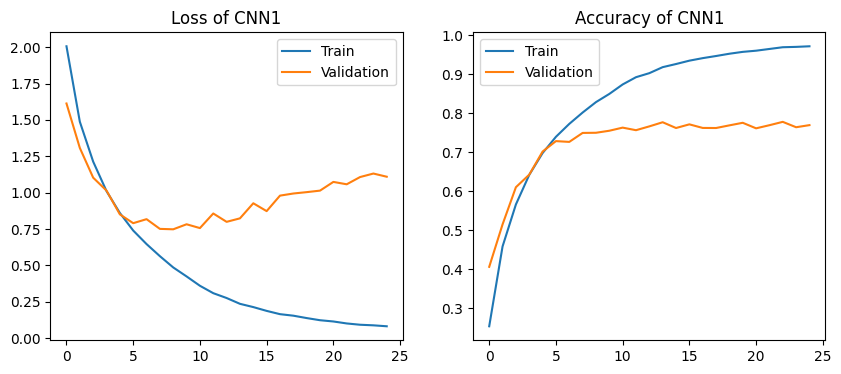

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(range(num_epochs),train_loss_1,label='Train')
axes[0].plot(range(num_epochs),validation_loss_1,label='Validation')
axes[0].legend()
axes[0].set_title('Loss of CNN1')

axes[1].plot(range(num_epochs),train_acc_1,label='Train')
axes[1].plot(range(num_epochs),validation_acc_1,label='Validation')
axes[1].legend()
axes[1].set_title('Accuracy of CNN1')
plt.show()

In [ ]:
cnn_1.eval()
with torch.no_grad():
  correct = 0
  total = 0
  test_predictions = np.array([])
  test_labels = np.array([])
  for i, data in enumerate(test_loader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = cnn_1(inputs)
      _, predicted = torch.max(predictions, 1)
      test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
      test_labels = np.concatenate((test_labels, labels.detach().cpu().numpy()))

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of CNN1 is : {:.2f}%'.format(100 * correct / total))


Accuracy of CNN1 is : 77.43%


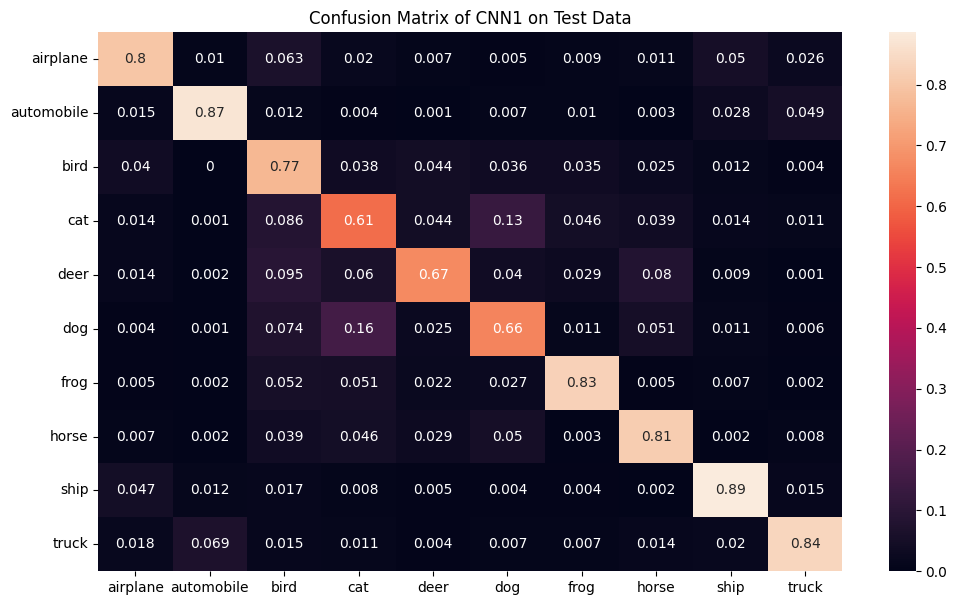

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_predictions)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in category],
                     columns = [i for i in category])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of CNN1 on Test Data')
plt.show()

### Conclusion
The model starts to overfitt since epoch 10 because we can obeserve that the validation loss increases after that. Also, the train accuracy is significantly greater than validation accuracy. So consider to add batchnorm and increase drop rate later


## CNN2

In [ ]:
class StudentCNN2(nn.Module):

    def __init__(self, num_class = 10):
        super(StudentCNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.drop1 = nn.Dropout(p=0.2)

        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 3,padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.drop2 = nn.Dropout(p=0.2)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size = 3,padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.drop3 = nn.Dropout(p=0.2)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(128*4*4,1024)
        self.relu1 = nn.ReLU()
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.drop = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(1024,512)
        self.relu2 = nn.ReLU()
        self.fc2_bn = nn.BatchNorm1d(512)

        self.fc3=nn.Linear(512,256)
        self.relu3 = nn.ReLU()
        self.fc3_bn = nn.BatchNorm1d(256)

        self.fc4 = nn.Linear(256,num_class)



    def forward(self, x):
      x = self.drop1(self.conv1_bn(self.pool1(self.act1((self.conv1(x))))))
      x = self.drop2(self.conv2_bn(self.pool2(self.act2((self.conv2(x))))))
      x = self.drop3(self.conv3_bn(self.pool3(self.act3((self.conv3(x))))))

      x = self.flat(x)

      x = self.drop(self.fc1_bn(self.relu1(self.fc1(x))))

      x = self.drop(self.fc2_bn(self.relu2(self.fc2(x))))
      x = self.drop(self.fc3_bn(self.relu3(self.fc3(x))))
      x = self.fc4(x)

      return(x)

In [ ]:
cnn_2 = StudentCNN2(num_class=10)
cnn_2.to(device)
summary(cnn_2,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
       BatchNorm2d-4           [-1, 32, 16, 16]              64
           Dropout-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
       BatchNorm2d-9             [-1, 64, 8, 8]             128
          Dropout-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
             ReLU-12            [-1, 128, 8, 8]               0
        MaxPool2d-13            [-1, 128, 4, 4]               0
      BatchNorm2d-14            [-1, 12

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(cnn_2.parameters(), lr = learning_rate, momentum = 0.2)
train_loss_2, validation_loss_2, train_acc_2, validation_acc_2 = train_model(cnn_2, train_loader, val_loader, optimizer, num_epochs = num_epochs)

Epoch 1:
Training Loss: 1.567  Validation Loss: 1.283  Training Accuracy: 0.438  Validation Accuracy: 0.533
------------------------------
Epoch 2:
Training Loss: 1.191  Validation Loss: 1.029  Training Accuracy: 0.58  Validation Accuracy: 0.636
------------------------------
Epoch 3:
Training Loss: 1.022  Validation Loss: 0.89  Training Accuracy: 0.643  Validation Accuracy: 0.692
------------------------------
Epoch 4:
Training Loss: 0.919  Validation Loss: 0.812  Training Accuracy: 0.678  Validation Accuracy: 0.711
------------------------------
Epoch 5:
Training Loss: 0.842  Validation Loss: 0.711  Training Accuracy: 0.709  Validation Accuracy: 0.747
------------------------------
Epoch 6:
Training Loss: 0.79  Validation Loss: 0.71  Training Accuracy: 0.729  Validation Accuracy: 0.748
------------------------------
Epoch 7:
Training Loss: 0.734  Validation Loss: 0.704  Training Accuracy: 0.745  Validation Accuracy: 0.753
------------------------------
Epoch 8:
Training Loss: 0.69  V

In [ ]:
torch.save(cnn_1.state_dict(), 'cnn_2.pth')


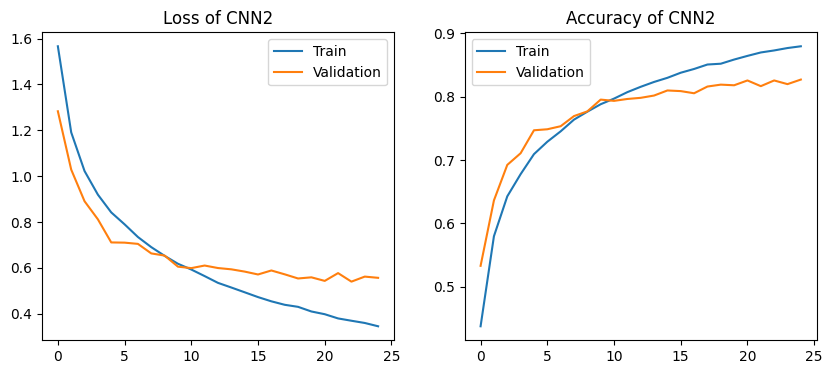

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(range(num_epochs),train_loss_2,label='Train')
axes[0].plot(range(num_epochs),validation_loss_2,label='Validation')
axes[0].legend()
axes[0].set_title('Loss of CNN2')

axes[1].plot(range(num_epochs),train_acc_2,label='Train')
axes[1].plot(range(num_epochs),validation_acc_2,label='Validation')
axes[1].legend()
axes[1].set_title('Accuracy of CNN2')
plt.show()

In [ ]:
cnn_2.eval()
with torch.no_grad():
  correct = 0
  total = 0
  test_predictions = np.array([])
  test_labels = np.array([])
  for i, data in enumerate(test_loader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = cnn_2(inputs)
      _, predicted = torch.max(predictions, 1)
      test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
      test_labels = np.concatenate((test_labels, labels.detach().cpu().numpy()))

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of CNN2 is : {:.2f}%'.format(100 * correct / total))




Accuracy of CNN1 is : 82.01%


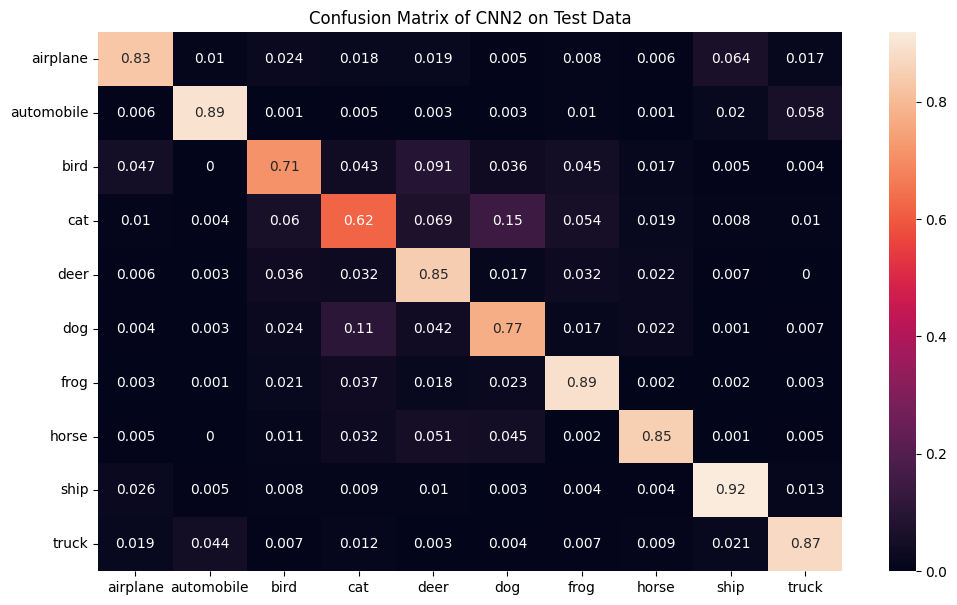

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_predictions)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in category],
                     columns = [i for i in category])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of CNN2 on Test Data')
plt.show()

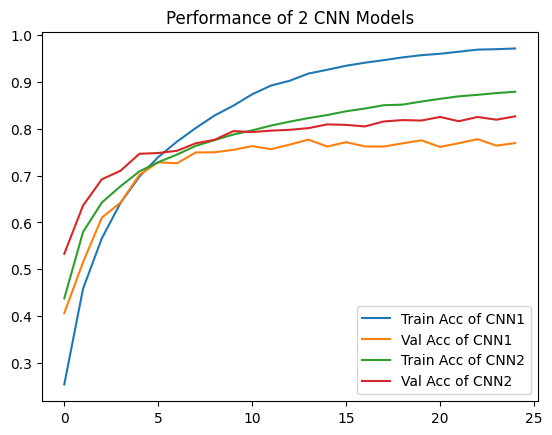

In [ ]:
plt.plot(range(num_epochs),train_acc_1,label='Train Acc of CNN1')
plt.plot(range(num_epochs),validation_acc_1,label='Val Acc of CNN1')
plt.plot(range(num_epochs),train_acc_2,label='Train Acc of CNN2')
plt.plot(range(num_epochs),validation_acc_2,label='Val Acc of CNN2')
plt.title('Performance of 2 CNN Models')
plt.legend()
plt.show()

### Conclusion
By adding batch normalization and more drop out layers, the performance of CNN2 is better on validation set and from the plot we can see the issue of overfitting has been fixed


## Transfer Learning - Resnet


In [ ]:
IMAGE_SIZE = 224 # We need to resize the images given resnet takes input of image size >= 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])


train_dataset =  datasets.CIFAR10(root='./data',
                               train=True,
                               download=True,
                               transform = composed)

test_dataset = datasets.CIFAR10(root='./data',
                                   train=False,
                                   download=True,
                                   transform = composed)

train_dataset, val_dataset = random_split(train_dataset, [45000, 5000])



train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)
test_loaders = DataLoader(test_dataset, batch_size = 100, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified


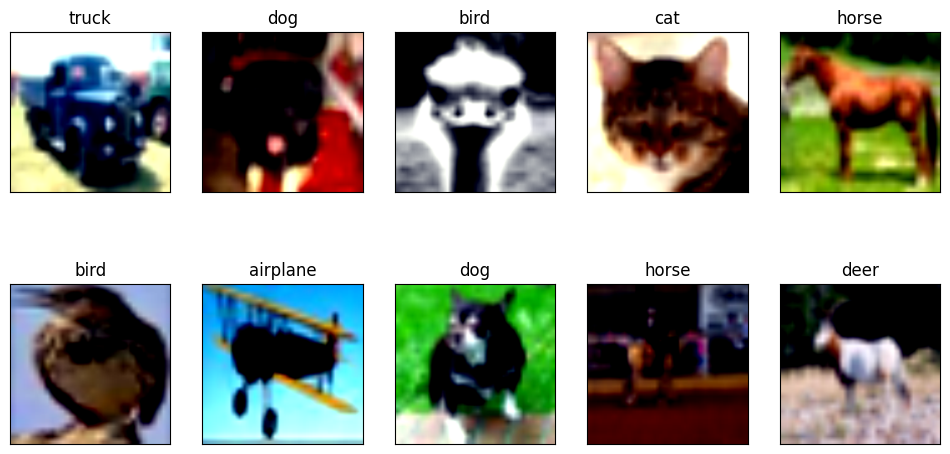

In [ ]:
def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple([0.4914, 0.4822, 0.4465])) + np.array(tuple([0.247, 0.243, 0.261]))
    img = img.clip(0, 1)
    return img


fig = plt.figure(figsize=(12, 6))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = train_dataset[idx][0]
    plt.imshow(im_convert(img))
    ax.set_title(category[train_dataset[idx][1]])


In [ ]:
def resnet_34():
    res_34 = torchvision.models.resnet34(pretrained=True)

    res_34.fc = torch.nn.Linear(resnet.fc.in_features, 10)

    torch.nn.init.xavier_uniform_(res_34.fc.weight)
    return res_34

resnet = resnet_34()
resnet.to(device)
summary(resnet,(3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(resnet.parameters(), lr = learning_rate, momentum = 0.2)
train_loss_3, validation_loss_3, train_acc_3, validation_acc_3 = train_model(resnet, train_loader, val_loader, optimizer, num_epochs = 5)

Epoch 1:
Training Loss: 0.315  Validation Loss: 0.18  Training Accuracy: 0.895  Validation Accuracy: 0.94
------------------------------
Epoch 2:
Training Loss: 0.081  Validation Loss: 0.163  Training Accuracy: 0.972  Validation Accuracy: 0.948
------------------------------
Epoch 3:
Training Loss: 0.03  Validation Loss: 0.131  Training Accuracy: 0.99  Validation Accuracy: 0.958
------------------------------
Epoch 4:
Training Loss: 0.013  Validation Loss: 0.139  Training Accuracy: 0.996  Validation Accuracy: 0.958
------------------------------
Epoch 5:
Training Loss: 0.006  Validation Loss: 0.127  Training Accuracy: 0.998  Validation Accuracy: 0.964
------------------------------


In [ ]:

torch.save(resnet.state_dict(), 'resnet_34.pth')


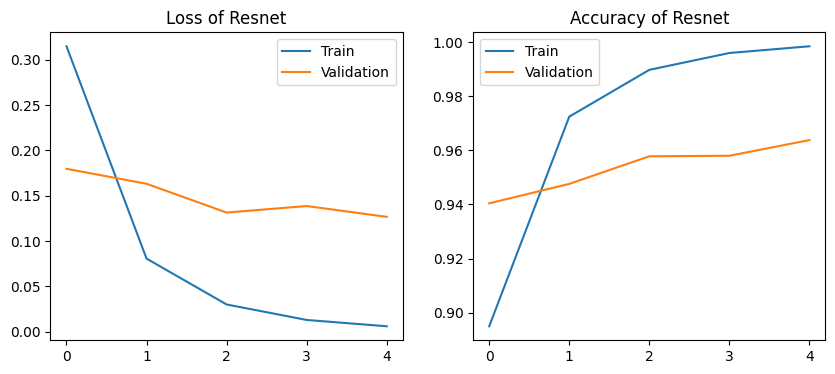

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(range(5),train_loss_3,label='Train')
axes[0].plot(range(5),validation_loss_3,label='Validation')
axes[0].legend()
axes[0].set_title('Loss of Resnet')

axes[1].plot(range(5),train_acc_3,label='Train')
axes[1].plot(range(5),validation_acc_3,label='Validation')
axes[1].legend()
axes[1].set_title('Accuracy of Resnet')
plt.show()

In [ ]:
resnet.eval()
with torch.no_grad():
  correct = 0
  total = 0
  test_predictions = np.array([])
  test_labels = np.array([])
  for i, data in enumerate(test_loaders, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = resnet(inputs)
      _, predicted = torch.max(predictions, 1)
      test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
      test_labels = np.concatenate((test_labels, labels.detach().cpu().numpy()))

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of Resnet34 is : {:.2f}%'.format(100 * correct / total))




Accuracy of Resnet34 is : 96.21%


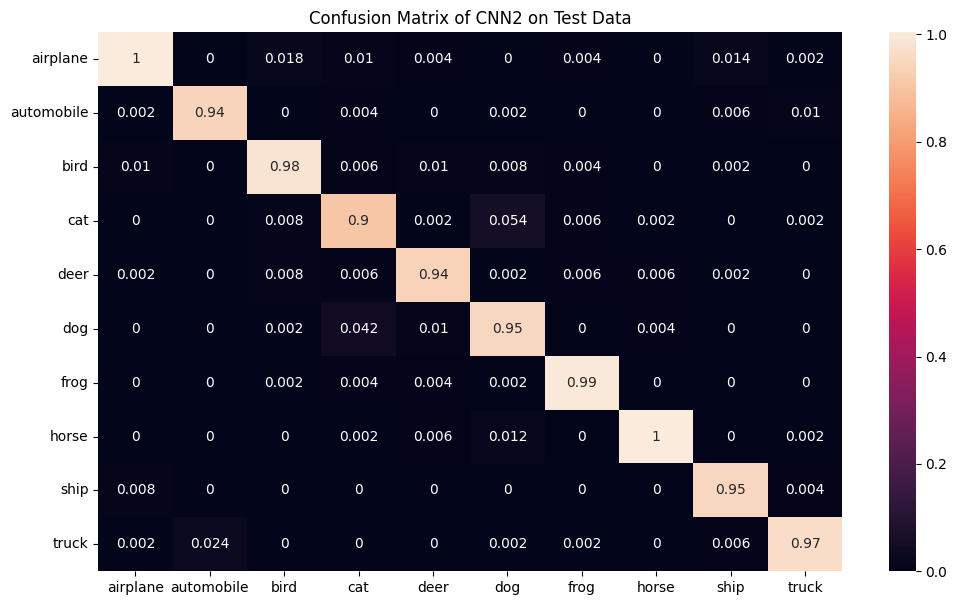

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_predictions)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in category],
                     columns = [i for i in category])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of CNN2 on Test Data')
plt.show()

# Data Shift


Files already downloaded and verified
Files already downloaded and verified


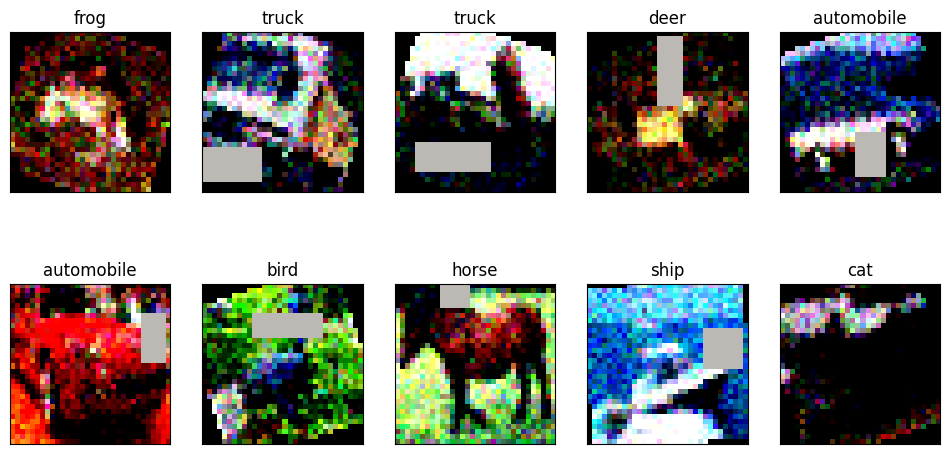

In [ ]:
def add_gaussian_noise(img, mean=0, std=0.1):
    noise = torch.randn_like(img) * std + mean
    noisy_img = img + noise
    return noisy_img

composed_shift = transforms.Compose([transforms.Resize((32, 32)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=0.1)),
                                     transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])

train_shift = datasets.CIFAR10(root='./data', train=True, download=True, transform=composed_shift)
test_dataset_shift = datasets.CIFAR10(root='./data', train=False, download=True, transform=composed_shift)

train_dataset_shift, val_dataset_shift = random_split(train_shift, [45000, 5000])

train_loader_shift = DataLoader(train_dataset_shift, batch_size=100, shuffle=True)
val_loader_shift = DataLoader(val_dataset_shift, batch_size=100, shuffle=True)
test_loader_shift = DataLoader(test_dataset_shift, batch_size = 100, shuffle=False)

fig = plt.figure(figsize=(12, 6))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = train_shift[idx][0]
    plt.imshow(im_convert(img))
    ax.set_title(category[train[idx][1]])

## CNN1 Shifted Evaluation

In [ ]:
'''
CNN1 evaluation on Shifted Data
'''
cnn_1.eval()
with torch.no_grad():
  correct = 0
  total = 0
  test_predictions = np.array([])
  test_labels = np.array([])
  for i, data in enumerate(test_loader_shift, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = cnn_1(inputs)
      _, predicted = torch.max(predictions, 1)
      test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
      test_labels = np.concatenate((test_labels, labels.detach().cpu().numpy()))

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of CNN1 on Shifted Data is : {:.2f}%'.format(100 * correct / total))



Accuracy of CNN1 on Shifted Data is : 42.26%


In [ ]:
print('Accuracy of Logistic Regression on Shifted Data is 34.86%')
print('Accuracy of CNN1 on Shifted Data is : 42.26%')
print('Accuracy of CNN2 on Shifted data is : 36.48%')
print('Accuracy of Resnet on Shifted Data is : 73.01%')

Accuracy of Logistic Regression on Shifted Data is 34.86%
Accuracy of CNN1 on Shifted Data is : 42.26%
Accuracy of CNN2 on Shifted data is : 36.48%
Accuracy of Resnet on Shifted Data is : 73.01%


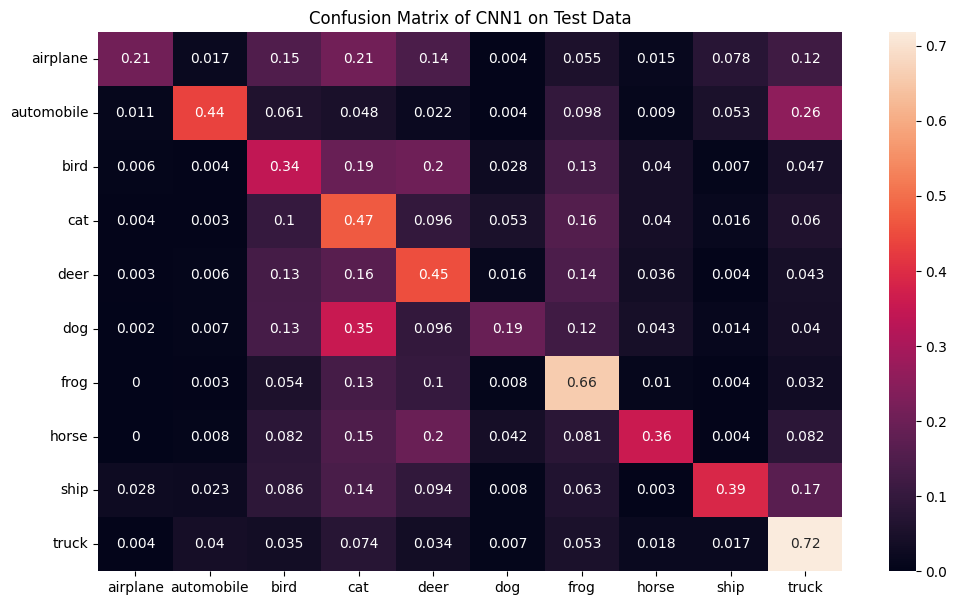

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_predictions)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in category],
                     columns = [i for i in category])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of CNN1 on Test Data')
plt.show()

## CNN2 Shifted Evaluation

In [ ]:
'''
CNN2 evaluation on Shifted Data
'''
cnn_2.eval()
with torch.no_grad():
  correct = 0
  total = 0
  test_predictions = np.array([])
  test_labels = np.array([])
  for i, data in enumerate(test_loader_shift, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = cnn_2(inputs)
      _, predicted = torch.max(predictions, 1)
      test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
      test_labels = np.concatenate((test_labels, labels.detach().cpu().numpy()))

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of CNN2 on Shifted data is : {:.2f}%'.format(100 * correct / total))



Accuracy of CNN2 on Shifted data is : 36.48%


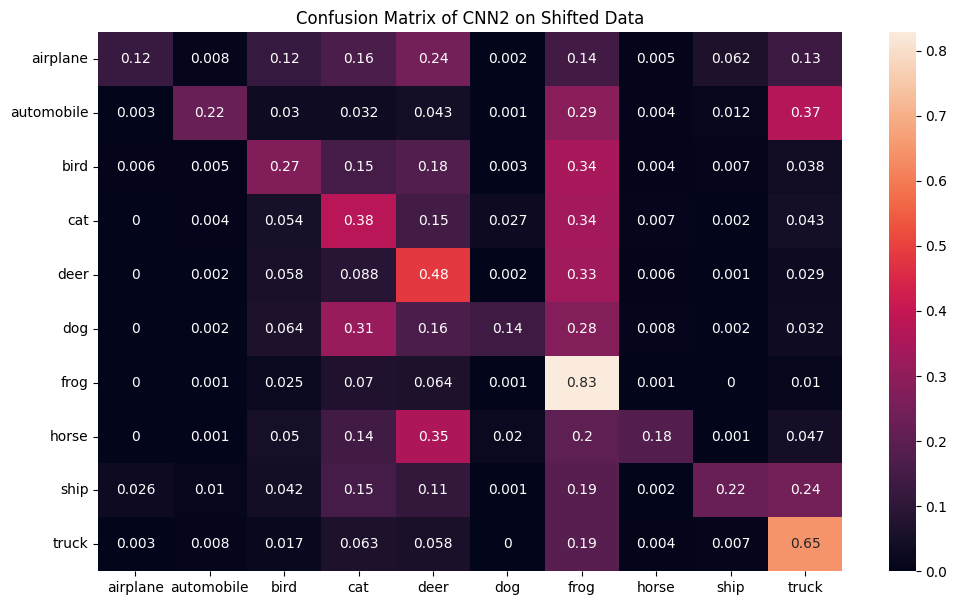

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_predictions)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in category],
                     columns = [i for i in category])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of CNN2 on Shifted Data')
plt.show()

## Resnet Shifted Evaluation

Files already downloaded and verified
Files already downloaded and verified


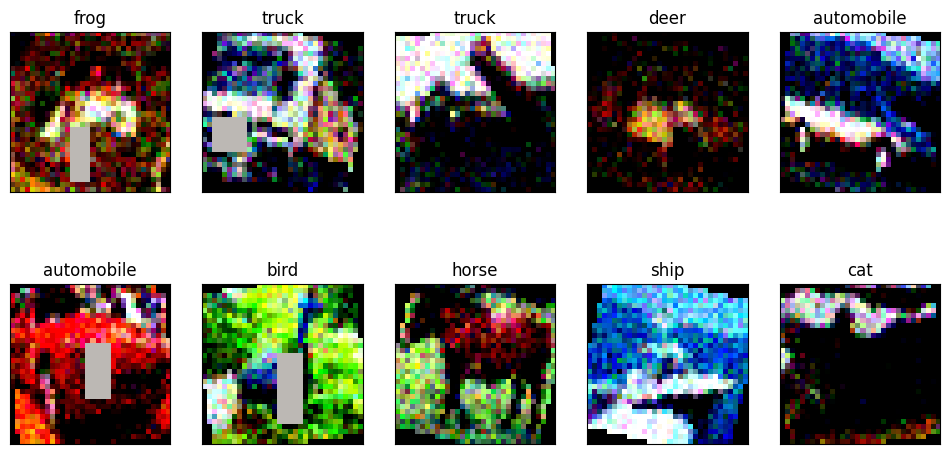

In [ ]:
IMAGE_SIZE = 224 # We need to resize the images given resnet takes input of image size >= 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

composed_shift = transforms.Compose([transforms.Resize((224, 224)), # Resize the image in a 224x224 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=0.1)),
                                     transforms.Normalize(mean, std),
                                     transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset =  datasets.CIFAR10(root='./data',
                               train=True,
                               download=True,
                               transform = composed_shift)

test_dataset = datasets.CIFAR10(root='./data',
                                   train=False,
                                   download=True,
                                   transform = transform_test)

train_dataset, val_dataset = random_split(train_dataset, [45000, 5000])



train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True)
test_loaders = DataLoader(test_dataset, batch_size = 100, shuffle=False)

fig = plt.figure(figsize=(12, 6))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = train_shift[idx][0]
    plt.imshow(im_convert(img))
    ax.set_title(category[train[idx][1]])







In [ ]:
resnet_shift = resnet_34()
resnet_shift.to(device)
summary(resnet_shift,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(resnet_shift.parameters(), lr = learning_rate, momentum = 0.2)
train_loss_4, validation_loss_4, train_acc_4, validation_acc_4 = train_model(resnet_shift, train_loader, val_loader, optimizer, num_epochs = 3)

Epoch 1:
Training Loss: 0.523  Validation Loss: 0.357  Training Accuracy: 0.824  Validation Accuracy: 0.88
------------------------------


In [ ]:

resnet_shift.eval()
with torch.no_grad():
  correct = 0
  total = 0
  test_predictions = np.array([])
  test_labels = np.array([])
  for i, data in enumerate(test_loaders, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = resnet_shift(inputs)
      _, predicted = torch.max(predictions, 1)
      test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
      test_labels = np.concatenate((test_labels, labels.detach().cpu().numpy()))

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of Resnet on Shifted Data is : {:.2f}%'.format(100 * correct / total))



Accuracy of Resnet on Shifted Data is : 73.01%


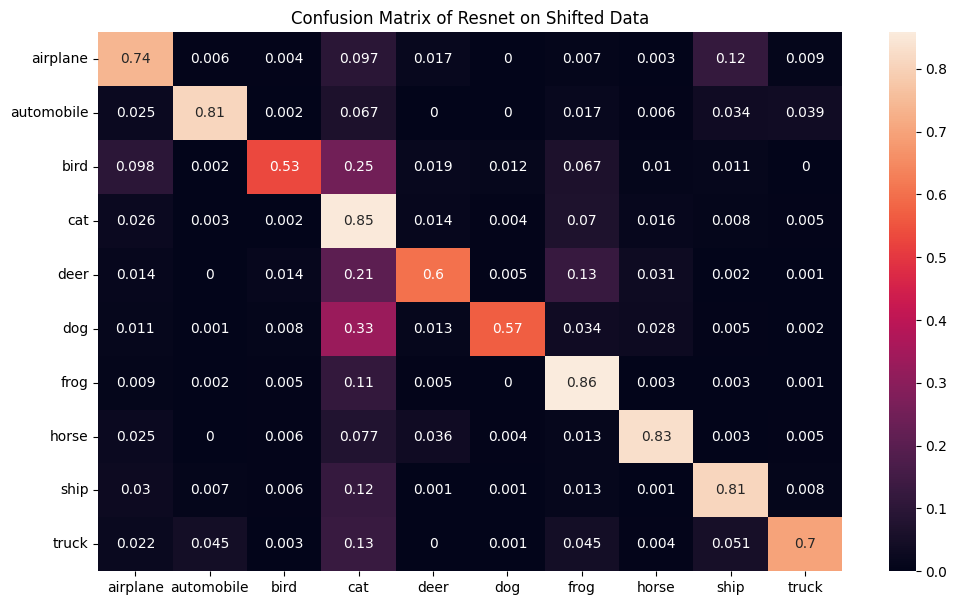

In [ ]:
cf_matrix = confusion_matrix(test_labels, test_predictions)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in category],
                     columns = [i for i in category])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of Resnet on Shifted Data')
plt.show()